# Proyecto - GARCH -Volatilidad dinámica - Joaquín Trejo

Implementar el siguiente modelo GARCH


$$
    \sigma_t^2 = (1 - \lambda) r^2_{t-1} + \lambda \sigma_{t-1}^2
$$

$$
\begin{aligned}
    s.t. \quad &\ 0< \lambda \leq 1\\
\end{aligned}
$$

$$
    \log L = \sum_{t=1}^T\left(\log \sigma_t^2 + \frac{r_t^2}{\sigma_t^2}\right)
$$


Dada la clase **GARCHSigmas** proporcionada para el modelo GARCH(1,1) descrito a continuación:


$$
    \sigma_t^2 = \omega + \alpha r^2_{t-1} + \beta\sigma^2_{t-1}
$$

$$
    \log L = \sum_{t=1}^T\left(\log \sigma_t^2 + \frac{r_t^2}{\sigma_t^2}\right)
$$



realizamos alfgunas modificaciones a la misma, en específico:

* Renombrándola: **GARCHSigmas_VD** (VD: Volatilidad dinámica)

* En incialización de la clase, en donde solo se tendrá un parámetro **lambda**, el cual es utilizado en los modelos EWMA (RiskMetrics utiliza un valor de lambda de .94%).

* Dentro de la función que genera el historico de sigmas: **get_sigma**, en donde se debe modificar la forma de cálculo de la volatilidad, es decir, sustituir:

$$
\quad \sigma_t^2 = \omega + \alpha r^2_{t-1} + \beta\sigma^2_{t-1}\quad 
por \quad \sigma_t^2 = (1 - \lambda) r^2_{t-1} + \lambda \sigma_{t-1}^2
$$

In [1]:
class GARCHSigmas_VD:
    """
    Clase para estimar sigmas para un GARCH(1, 1)
    """
    def __init__(self, Lambda, sigma_init, R):
        self.Lambda = Lambda
        self.R = R
        self.sigma_hist = [sigma_init]
        self.initialize_sigmas()
        
    def get_sigma(self, t):
        """
        Calcula sigma_t dado datos en t - 1
        """
        
        rt0 = 0 if t == 0 else self.R.iloc[t - 1, 0]
        sigma0 = self.sigma_hist[-1]
        sigma1 = (1 - self.Lambda) * (rt0 ** 2) + (self.Lambda * sigma0)#Aplicamos la nueva fórmula de cálculo para la volatilidad
        self.sigma_hist.append(sigma1)
    
    def initialize_sigmas(self):
        N, M = self.R.shape
        for t in range(N - 1, -1, -1):
            self.get_sigma(t)

Ahora bien, la función **LGarch**, genera la logverosimilitud del modelo GARCH, por lo que tambièn debe ser modificada, tanto en el nombre (**LGarchVI**) como ajustandola de tal forma que solo tome los siguientes parámetros 

In [2]:
def LGarchVD(Lambda,sigma_int, R):
    s = GARCHSigmas_VD(Lambda, sigma_init, R)
    sigma_hist = np.array(s.sigma_hist[1:])
    r1_2 = R.values.ravel()**2
    log_likelihood = (np.log(sigma_hist) + r1_2 / sigma_hist).sum()/2
    return log_likelihood

A partir de este punto debemos obtener los insumos a utilizar:

* Los precios y rendimientos de las acciones
* El vector R de rendimeintos de mercado (MEXBOL)


In [3]:
#Importamos la librerías a utilizar en el notebook
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.random import randn, seed
from scipy.optimize import minimize

In [4]:
%config InlineBackend.figure_format = 'retina'
market = pd.read_excel("Prueba.xlsx", index_col=0)
market.columns =[c.replace(" MF Equity","").replace(" INDEX","") for c in market.columns]
market.head()

,KIMBERA,GAPB,CEMEXCPO,ASURB,GFNORTEO,KOFUBL,AC*,LABB,FEMSAUBD,OMAB,...,MEGACPO,GCC*,BIMBOA,GMEXICOB,GCARSOA1,TLEVICPO,ALFAA,BSMXB,PINFRA*,MEXBOL
DATE,,,,,,,,,,,,,,,,,,,,,
2016-01-01,40.37,152.05,8.72,243.89,94.99,123.90,104.68,13.85,161.63,83.61,...,64.19,44.81,45.95,36.79,70.98,94.34,34.10,30.25,202.73,42977.50
2016-01-04,39.16,148.57,8.43,238.29,91.79,120.29,102.09,14.41,157.62,81.77,...,64.45,43.51,45.02,35.71,69.83,92.62,33.74,29.46,202.93,42113.70
2016-01-05,38.89,147.93,8.31,233.03,91.72,118.82,101.12,13.77,157.80,81.58,...,63.16,43.51,45.77,36.45,70.70,91.89,33.99,29.72,203.56,42041.68
2016-01-06,39.13,146.99,8.29,231.97,91.63,120.32,102.50,13.65,156.37,82.03,...,63.27,43.51,45.97,35.57,70.47,90.41,33.65,29.67,199.80,41691.19
2016-01-07,39.16,141.32,7.64,230.71,89.54,120.20,101.16,13.25,155.14,80.94,...,62.78,42.76,46.18,35.01,68.15,90.23,31.46,28.50,196.75,40661.57


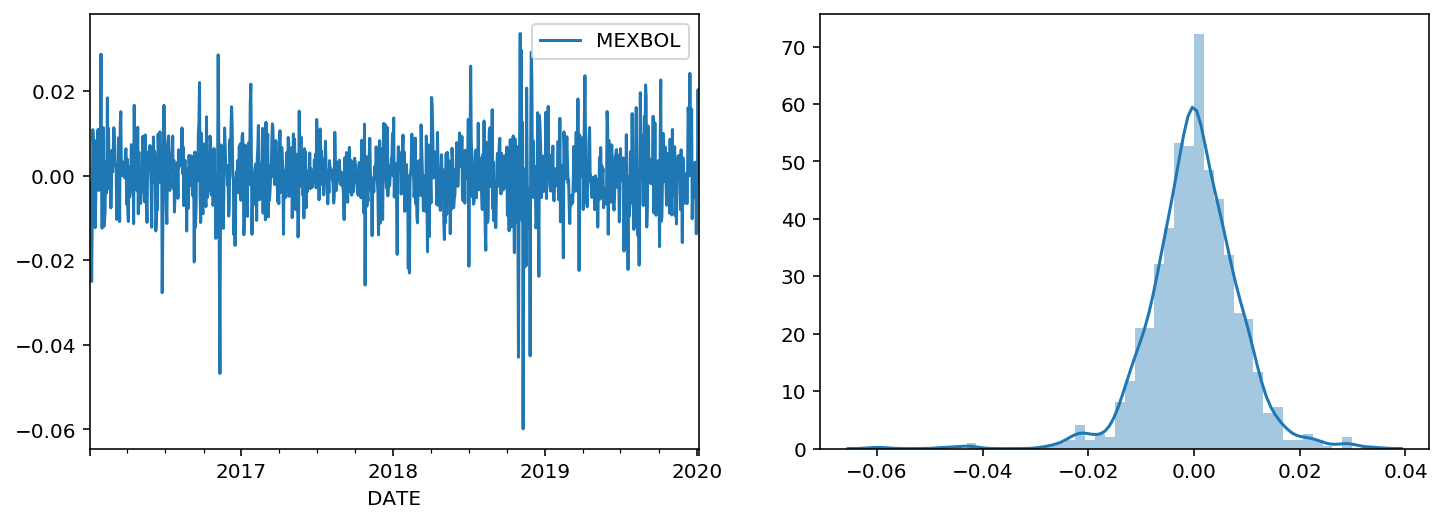

In [5]:
R = market[["MEXBOL"]]
R = np.log(R).diff().dropna() #Se aplica log para suavizar la serie
fig, ax = plt.subplots(1,2,figsize=(12,4))
R.plot(ax=ax[0])
sns.distplot(R,ax=ax[1]);

Inicializamos **Lambda** con un valor aleatorio y asignamos a **sigma_init** el valor de la Varianza de los rendimientos de **MEXBOL**

In [6]:
seed(314)
Lambda = np.abs(randn(1))
sigma_init = R.var(ddof = 1).item() / 252

/Users/joaquinguillermotrejoberriel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: `item` has been deprecated and will be removed in a future version
  This is separate from the ipykernel package so we can avoid doing imports until


Configuramos el modelo:

* Definimos x0 como un arreglo de un solo elemento (esto para poder utilizar minimize), mismo será el parámetro a variar hasta encontrar la solución de la función a minimizar.
* Definimos la función a minimizar **L_part_VD**, la cual generará la log verosimilitud.
* Definimos las funciones **cons1** y **cons2**, la cuales serán utilizadas como constraints para limitar el valor de **lambda** [0,1].
* Definmos los boub

In [7]:
x0 = np.array([Lambda])

L_part_VD = lambda x0: LGarchVD(*x0, sigma_init,R)

def cons1(x):
    return 1 - x[0]

def cons2(x):
    return x[0]

Ahora generamos la lista de contraints y aplicamos minimize para obtener el valor de **lambda** que minimiza la función **L_part_VI** :

In [8]:
constraints = [{"type": "ineq", "fun":cons1},
               {"type": "ineq", "fun":cons2}]

fmin = minimize(L_part_VD, x0,
               constraints = constraints)

/Users/joaquinguillermotrejoberriel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log
  """


Los resultados obtenidos son:

El valor de **lambda** que minimiza la verosimilitud es:

In [9]:
print(fmin.x)

[0.90886798]


Ahora vamos a:

* Asignar a la variable  **Lambda_garch**, el valor de lambda que minimizó la función **L_part_VI**.
* Asignar el primer valor de las volatilidades a **sigma0**.
* Generar una lista en donde se almacenarán las volatilidades a predecir:

In [10]:
Lambda_garch = fmin.x
sigma0 = sigma_init
garch_predict = []
for i in range(len(R)):
    sigma0 = (1 - Lambda_garch) * R.iloc[i].item() ** 2 + Lambda_garch * sigma0
    garch_predict.append(sigma0)

/Users/joaquinguillermotrejoberriel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: `item` has been deprecated and will be removed in a future version
  """


Finalmente, graficamos las volatilidades calculadas con ambos modelos:

**Nota** : Se debe ejecutar todo el código de la sección **ANEXOS: Clase e implementación del modelo GARCH(1,1)**,  para poder continuar graficar las volatilidades del modelo GARCH(1,1).

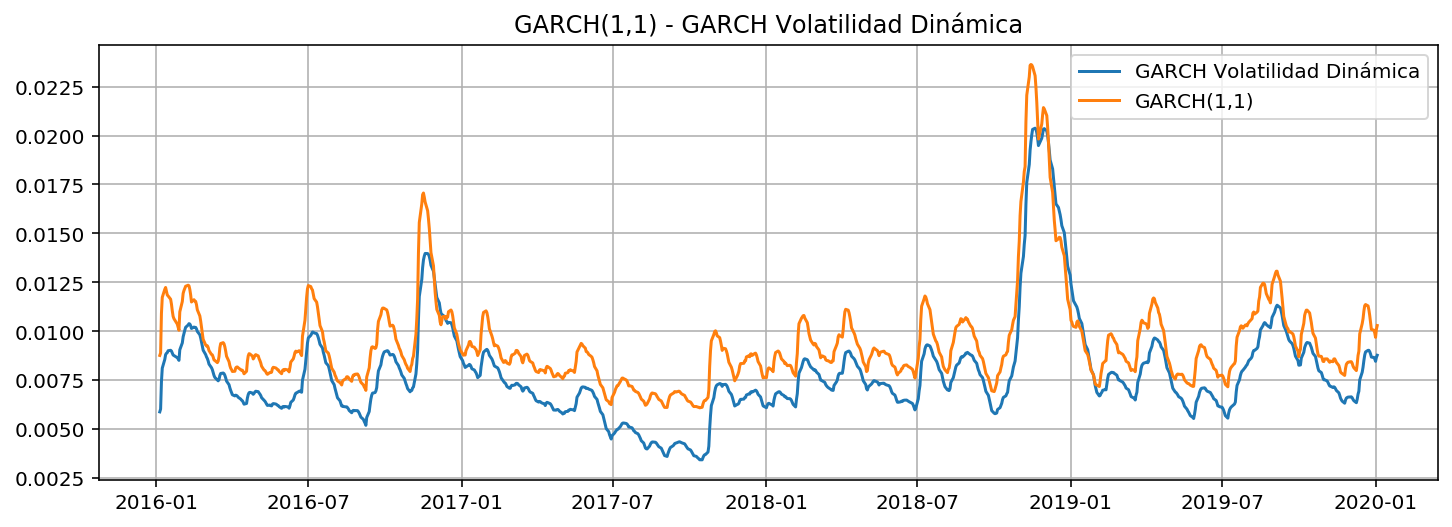

In [21]:
xaxis = R.index[1:]
sigma_garch = pd.Series(np.sqrt(garch_predict).ravel())[1:]

plt.subplots(figsize =(12,4))
plt.title("GARCH(1,1) - GARCH Volatilidad Dinámica")
plt.grid()
plt.plot(xaxis , sigma_garch.ewm(com=5).mean(),label = "GARCH Volatilidad Dinámica")
plt.plot(xaxis , sigma_garchG.ewm(5).mean(),label = "GARCH(1,1)")
plt.legend();

## ANEXOS: Clase e implementación del modelo GARCH(1,1)

In [12]:
class GARCHSigmas:
    """
    Clase para estimar sigmas para un GARCH(1, 1)
    """
    def __init__(self, omega, alpha, beta, sigma_init, R):
        self.omega = omega
        self.alpha = alpha
        self.beta = beta
        self.R = R
        self.sigma_hist = [sigma_init]
        self.initialize_sigmas()
        
    def get_sigma1(self, t):
        """
        Calcula sigma_t dado datos en t - 1
        """
        
        rt0G = 0 if t == 0 else self.R.iloc[t - 1, 0]
        sigma0G = self.sigma_hist[-1]
        sigma1G = self.omega + self.alpha * rt0G ** 2 + self.beta * sigma0G
        self.sigma_hist.append(sigma1G)
    
    def initialize_sigmas(self):
        N, M = self.R.shape
        for t in range(N - 1, -1, -1):
            self.get_sigma1(t)

In [13]:
def LGarch(omega, alpha, beta, sigma_init, R):
    s = GARCHSigmas(omega, alpha, beta, sigma_init, R)
    sigma_histG = np.array(s.sigma_hist[1:])
    r1_2G = R.values.ravel()**2
    log_likelihood = (np.log(sigma_histG) + r1_2G / sigma_histG).sum()/2
    return log_likelihood

In [14]:
seed(314)
omega, alpha, beta = np.abs(randn(3))
LGarch(omega, alpha, beta, sigma_init, R)

57.23125325842286

In [15]:
#Configuraciòn del modelo
x1 = np.array([omega, alpha, beta ])
L_part = lambda x1: LGarch(*x1, sigma_init,R)

def cons(x):
    return x[1] + x[2] - 1

bounds = [
    (0,None),
    (0,None),
    (0,None)
    ]

In [16]:
fmin2 = minimize(L_part, x1,
               constraints = {"type": "ineq", "fun":cons},
               bounds = bounds)

/Users/joaquinguillermotrejoberriel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
/Users/joaquinguillermotrejoberriel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """
/Users/joaquinguillermotrejoberriel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/Users/joaquinguillermotrejoberriel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in add
  """


In [17]:
fmin2

     fun: -4432.665752309834
     jac: array([5337.45831299,  200.69342041,  200.86517334])
 message: 'Optimization terminated successfully.'
    nfev: 175
     nit: 28
    njev: 28
  status: 0
 success: True
       x: array([5.50912795e-06, 2.01014074e-01, 7.98986039e-01])

In [18]:
omega_garch, alpha_garch, beta_garch = fmin2.x

In [19]:
sigma0G = sigma_init
garch_predictG = []
for i in range(len(R)):
    sigma0G = omega_garch + alpha_garch * R.iloc[i].item() ** 2 + beta_garch * sigma0G
    garch_predictG.append(sigma0G)

/Users/joaquinguillermotrejoberriel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: `item` has been deprecated and will be removed in a future version
  after removing the cwd from sys.path.


In [20]:
sigma_garchG = pd.Series(np.sqrt(garch_predictG)[1:])